# Identifying the Order of a  Moving Average Process

The steps are similar as the random walk. However just after identifying that there is an autocorrelation in the time series, which is not a random walk, we check that if the autocorrelation coefficients become abruptly non-significant after lag q. If it does, it is an MA(q) process. If its not, its not a moving average process. The below is the example of the flowchart:

- Gather Data
- Is it stationary? No -> Apply transformations 
- Yes -> Plot ACF
- Is there autocorrelation? No -> It is a random walk
- Yes -> Do autocorrelation coefficients become abruptly non-significant after lag q?
- Yes -> It is an MA(q) process No -> Not a moving average process

In [1]:
#Gather Data
import pandas as pd

data = pd.read_csv("C:/Users/Drew/Downloads/widget_sales.csv")
data.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


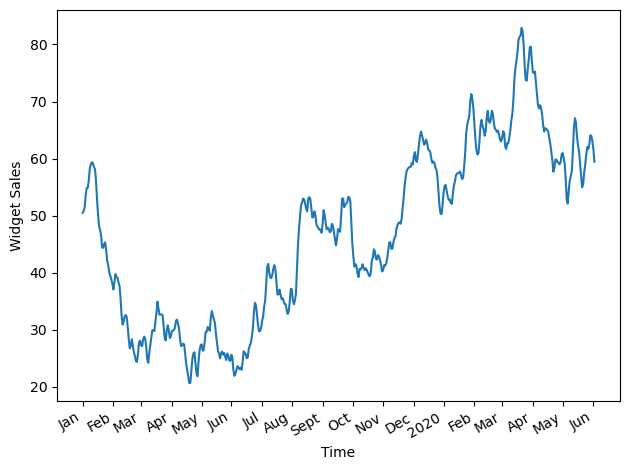

In [2]:
import matplotlib.pyplot as pt

fig, ax = pt.subplots()
ax.plot(data['widget_sales'])
ax.set_xlabel("Time")
ax.set_ylabel("Widget Sales")

pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])

fig.autofmt_xdate() #Tilt the labels on the x-axis ticks so that they display nicely
pt.tight_layout() #Remove extra whitespace around the figure

In [3]:
#Test for Stationarity
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(data['widget_sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-value: {ADF_result[1]}')

ADF Statistic: -1.512166206935896
P-value: 0.5274845352272648


This result is an ADF statistic of -1.51 and p-value of 0.53. Here, the ADF statistic is not a large negative number and the p-value is greater than 0.05. Hence, this time series is not stationary, we must apply transformations to make it stationary.

In order to make it stationary, we will try to stabilize the trend by applying a first-order differencing. We can do so by using the diff method from the numpy library. Remember that this method takes in a parameter n that specifies the order of differencing. In this case, because it is a first-order differencing, the n will be equal to 1.

In [4]:
#Transformation
import numpy as np

widget_sales_diff = np.diff(data['widget_sales'], n=1)

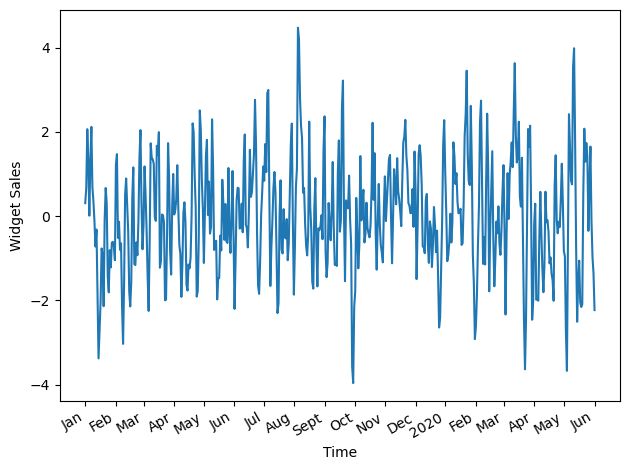

In [5]:
fig, ax = pt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel("Time")
ax.set_ylabel("Widget Sales")
pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])

fig.autofmt_xdate() #Tilt the labels on the x-axis ticks so that they display nicely
pt.tight_layout() #Remove extra whitespace around the figure

In [6]:
widget_sales_ADF = adfuller(widget_sales_diff)
print(f'ADF Statistic: {widget_sales_ADF[0]}')
print(f'P-Value: {widget_sales_ADF[1]}')

ADF Statistic: -10.576657780341957
P-Value: 7.076922818587346e-19


Now that the time series data is stationary. The next step is plotting the autocorrelation function (ACF).

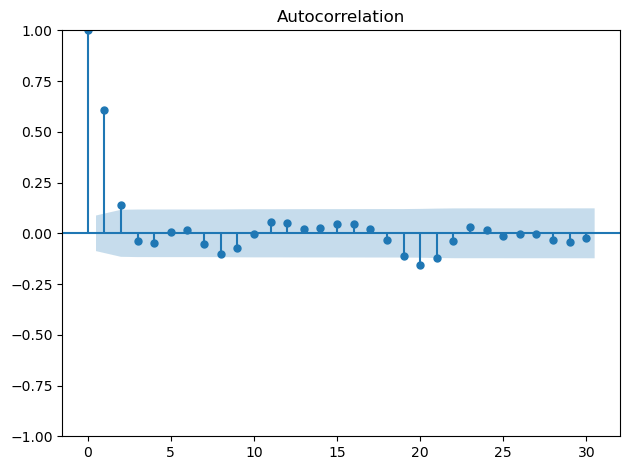

In [7]:
#Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(widget_sales_diff, lags=30)
pt.tight_layout()

There are significant coefficients up until lag 2. Then they abruptly become non-significant, as they remain in the shaded area of the plot. This means that we have a stationary moving average process of order 2. We can use a second-order moving average model, or MA(2) model, to forecast our stationary time series.

The ACF plot helps us determine the order of a moving average process. The ACF plot will show significant autocorrelation coefficients up until lag q, after which all coefficients will be non-significant. We can then conclude that we have a moving average process of order q, or an MA(q) process.

Since we know it is a MA(2) process, we can proceed to forecasting a moving average process.

# Forecasting a Moving Average Process

In [8]:
data_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = data_diff[:int(0.9*len(data_diff))]
test = data_diff[int(0.9*len(data_diff)):]

print(len(train))
print(len(test))

449
50


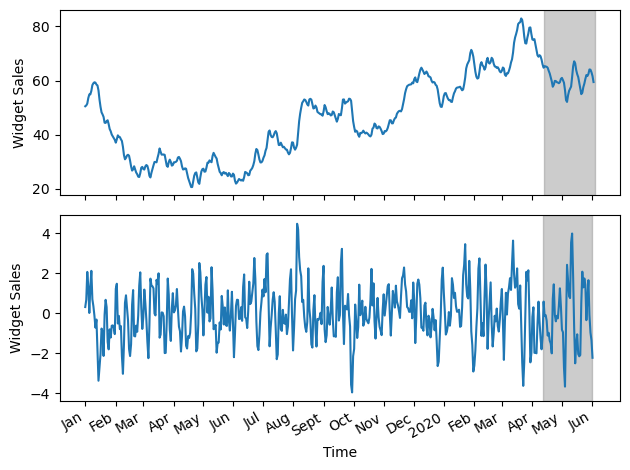

In [9]:
fig, (ax1, ax2) = pt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(data['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget Sales')
ax1.axvspan(450, 500, color="#808080", alpha=0.4)

ax2.plot(data_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget Sales')
ax2.axvspan(449, 498, color="#808080", alpha=0.4)

pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])

fig.autofmt_xdate() #Tilt the labels on the x-axis ticks so that they display nicely
pt.tight_layout() #Remove extra whitespace around the figure


The Moving Average (MA) model does not allow us to forecast 50 steps forward or even more forward etc in one shot. This model linearly dependent on past error terms, and those terms are not observed in the dataset, therefore they must be recursively estimated. 

In other words, it means that the Moving Average (MA) model can only forecast q (lag) steps into the future. Any prediction beyond that point will not have past error terms, and the model will only predict the mean. Thus, there is no added value in forecasting beyond q steps into the future, because the predictions will fall flat, as only the mean is returned, which is equivalent to a baseline model.

To avoid predicting the mean beyond two timesteps into the future, we need to develop a function that will predict two timesteps or less at a time, until 50 predictions are made, so that we can compare our predictions against the observed value of the test set. This method is called rolling forecasts. On first pass, we will train on the first 449 timesteps and predict timesteps 450 and 451. Then, on thje second pass, we will train on the first 451 timesteps, and predict timesteps 452 and 453. This is repeated until we finally predicted the values at timesteps 498 and 499.

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#The function takes in a DataFrame containing the full simulated moving average process. We also pass in the length of the
#training set (800 in this case) and the horizon of the forecast (200). The next parameter specifies how many steps at a time
#we wish to forecast (2). Finally, we specify the method to use to make forecasts
def rolling_forecast(data: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'mean' :
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(data[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = data[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range (window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA


In [11]:
pred_data = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_data['pred_mean'] = pred_mean
pred_data['pred_last_value'] = pred_last_value
pred_data['pred_MA'] = pred_MA

pred_data.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


Keep in mind we are still working with the differenced dataset, so our predictions are also differenced values. 

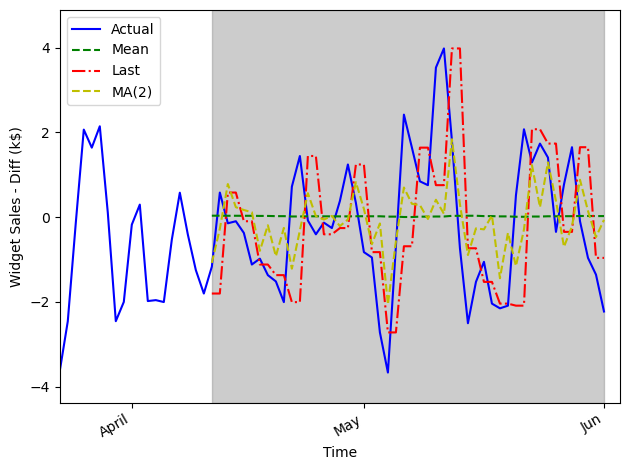

In [19]:
fig, ax = pt.subplots()

ax.plot(data_diff['widget_sales_diff'], 'b-', label="Actual")
ax.plot(pred_data['pred_mean'], 'g--', label="Mean")
ax.plot(pred_data['pred_last_value'], 'r-.', label="Last")
ax.plot(pred_data['pred_MA'], 'y--', label="MA(2)")
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales - Diff (k$)')
ax.axvspan(449, 498, color="#808080", alpha=0.4)
pt.xticks([439,468,498],
          ['April', 'May', 'Jun'])
ax.legend(loc=2)
ax.set_xlim(430,500)
fig.autofmt_xdate() #Tilt the labels on the x-axis ticks so that they display nicely
pt.tight_layout() #Remove extra whitespace around the figure

In the figure above, the prediction coming from the historical mean, shown as a dotted line, is almost a straight line. This is expected because the process is stationary, so the historical mean should be stable over time.

The next step is to measure the performance of our models. To do so, we will calculate the mean squared error (MSE) using the mean_squared_error function. We simply need to pass in the observed values (actual) and the predicted values into the function.

In [23]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_data['widget_sales_diff'], pred_data['pred_mean'])
mse_last = mean_squared_error(pred_data['widget_sales_diff'], pred_data['pred_last_value'])
mse_MA = mean_squared_error(pred_data['widget_sales_diff'], pred_data['pred_MA'])

print("The MSE of Mean is: ",mse_mean)
print("The MSE of Last is: ", mse_last)
print("The MSE of MA is: ", mse_MA)

The MSE of Mean is:  2.5606299456880537
The MSE of Last is:  3.2494260812249225
The MSE of MA is:  1.9481714497973228


As per the results, the best performing forecasting method is MA(2) model as it has the lowest MSE among the other two methods. This is expected because we previously identified a second-order moving average process for the differenced volume of widget sales, thus resulting in a smaller MSE compared to the naive forecasting methods. 

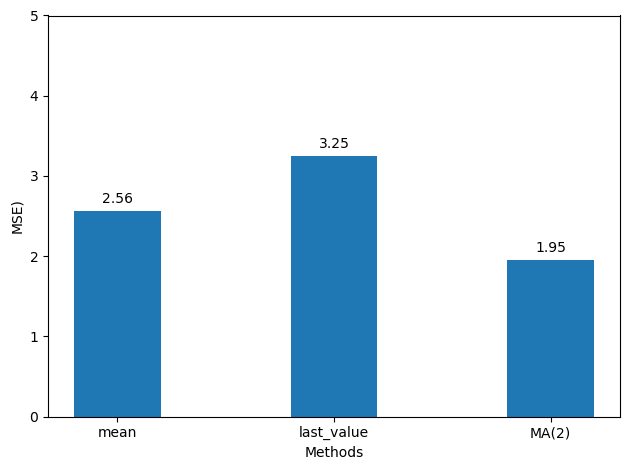

In [26]:
fig, ax = pt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [2.56, 3.25, 1.95]

#Histogram
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE)')
ax.set_ylim(0, 5)

for index, value in enumerate(y): #Display the value on top of the bar 
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center') #y= value + 1 is to position the text slightly above the bar so it does not overlap

pt.tight_layout()

Now once we have our champion model, here is a very important part. We need to inverse transform our predictions to bring them back to the original scale of the untransformed dataset. This is because it will not make sense presenting the differenced value to the stakeholders etc. with no knowledge of this. 

To obtain our predictions in the original scale of our dataset, we need to use the first value of the test as our initial value. Then, we can perform a cumulative sum to obtain a series of 50 predictions in the original scale of the dataset. We will assign these predictions to the pred_widget_sales column.

In [29]:
data['pred_widget_sales'] = pd.Series() #Initialize an empty column to hold our predictions
#Inverse transform the predictions to bring them back to the original scale of the dataset
data['pred_widget_sales'][450:] = data['widget_sales'].iloc[450] + pred_data['pred_MA'].cumsum() 

C:\Users\Drew\AppData\Local\Temp\ipykernel_10836\3889102545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_widget_sales'][450:] = data['widget_sales'].iloc[450] + pred_data['pred_MA'].cumsum()


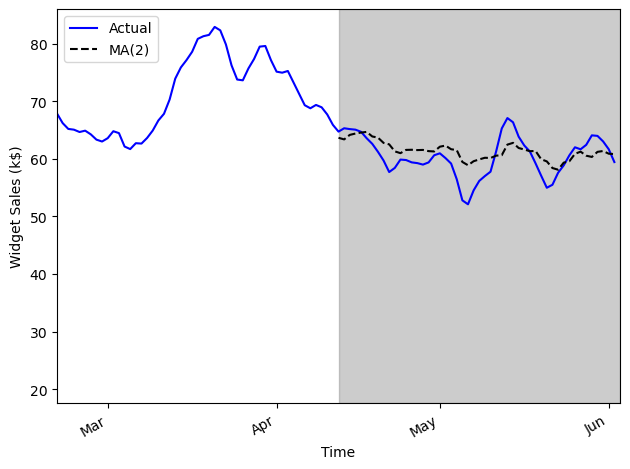

In [30]:
fig, ax = pt.subplots()

ax.plot(data['widget_sales'], 'b-', label='Actual')
ax.plot(data['pred_widget_sales'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k$)')
ax.axvspan(450, 500, color="#808080", alpha=0.4)
ax.set_xlim(400,500)
pt.xticks([409, 439, 468, 498],
          ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
pt.tight_layout()

Lastly, the final step is to report the MSE on the original dataset. We can measure the mean absolute error (MAE) using the mean_absolute_error function. This metric returns the average of the absolute difference between the predicted and actual values, instead of a squared difference like the MSE.

In [31]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(data['widget_sales'].iloc[450:], 
                                    data['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.324470924491554


This prints out an MAE of 2.32. Therefore, our predictions are on average off by $2,320, either above or below the actual value. Remember that our data has units of thousands of dollars, so we multiply the MAE by 1000 to express the average absolute difference.

# Summary

- A moving average process states that the present value is linearly dependent on the mean, present error term, and past error terms. The error terms are normally distributed.

- You can identify the order q of a stationary moving average process by studying the ACF plot. The coefficients are significant until lag q only.

- You can predict up to q steps into the future because the error terms are not observed in the data and must be recursively estimated.

- Predicting beyond q steps into the future will simply return the mean of the series. To avoid that, you can apply rolling forecasts.

- If you apply transformation to the data, you must undo it to bring your predictions back to the original scale of the data.

- The moving average model assumes the data is stationary. Thus, you can only use this model on stationary data.ary data. 